# ERA5 Precipitation #

API request form [CopernicusDataStore](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=overview). In order to do this from code line, it is important to remeber that we need a CDS password to access the ERA5 data.

In [1]:
import sys
import netCDF4 

print(f"Python executable path: {sys.executable}")
print(f"netCDF4 version: {netCDF4.__version__}")

Python executable path: /home/nagibemg/miniconda3/envs/hw2/bin/python
netCDF4 version: 1.7.4


In [19]:
# autoreload (so edits to .py load instantly)
%load_ext autoreload
%autoreload 2
# Import the real function for the daily download, processing and storage
from RealDailyRoutineERA5 import real_run_control_flow, plot_precip_scatter
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Variable(s) to be downloaded and other specs
START = datetime(2014, 5, 1)
END = datetime(2014, 5, 2)
VARS = 'total_precipitation'
STAT = 'daily_sum'

In [4]:
# run function
print("Launching ERA5 Processing Chain...")
real_run_control_flow(StartDate=START, 
                      EndDate = END, 
                      date_arg=None,
                      variables=VARS,
                      statistic= STAT
                     )

Launching ERA5 Processing Chain...
Scanning for missing data between 2014-05-01 and 2014-05-02...

Starting pipeline for: 2014-05-01


2026-02-01 21:43:56,996 INFO Request ID is bb7ea91d-11b8-4dbf-82ff-919030a4e699
2026-02-01 21:43:57,276 INFO status has been updated to accepted
2026-02-01 21:44:11,455 INFO status has been updated to successful
                                                                                

Regridding to HEALPix (NSIDE 128).
  ... Processing NSIDE=128
Appending to Zarr store: era5_precipitation.zarr
Data for 2014-05-01 saved to era5_precipitation.zarr

Starting pipeline for: 2014-05-02


2026-02-01 21:44:13,130 INFO Request ID is 4ae8ce66-a5f8-499e-bd57-414e9bc1a4f6
2026-02-01 21:44:13,187 INFO status has been updated to accepted
2026-02-01 21:44:26,732 INFO status has been updated to running
2026-02-01 21:44:34,402 INFO status has been updated to successful
                                                                                

Regridding to HEALPix (NSIDE 128).
  ... Processing NSIDE=128
Appending to Zarr store: era5_precipitation.zarr
Data for 2014-05-02 saved to era5_precipitation.zarr


Download working until here. Still need to decide how to regrid and how to incorporate parallel processing. 

Max Precip Value: 116.66 mm


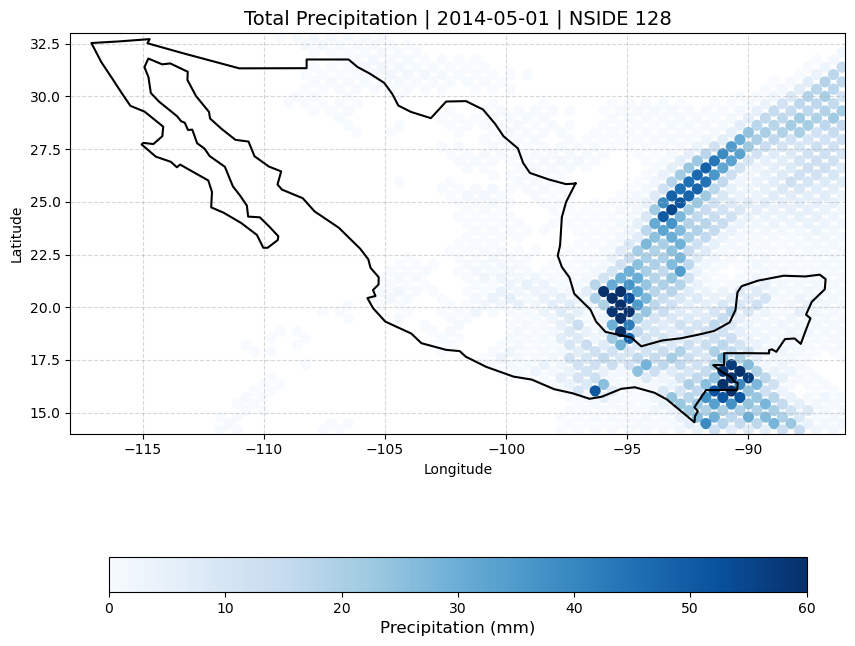

Max Precip Value: 99.71 mm


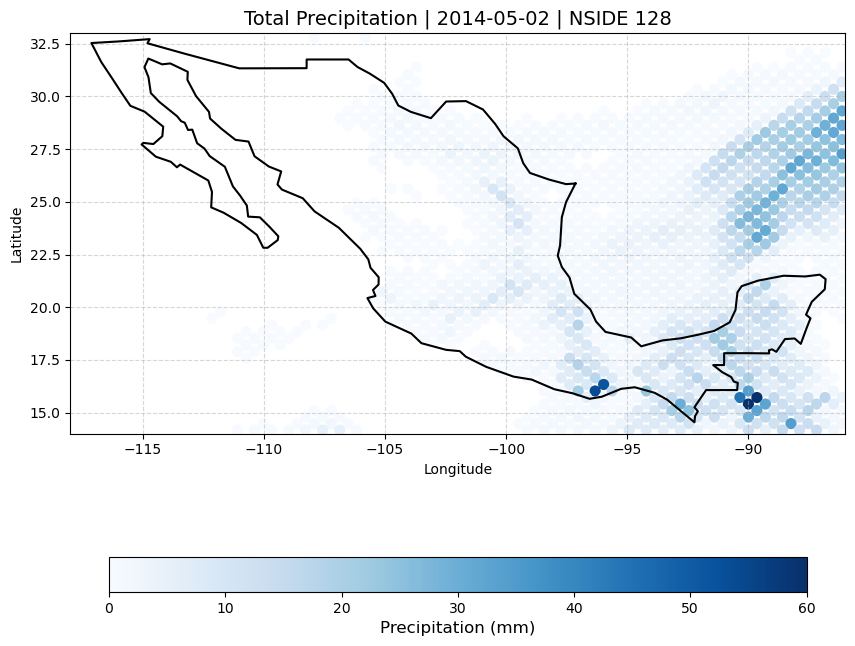

In [25]:
plot_precip_scatter("era5_precipitation.zarr", target_date="2014-05-01", nside_val=128)
plot_precip_scatter("era5_precipitation.zarr", target_date="2014-05-02", nside_val=128)